In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os
import configs
from math import ceil, floor

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
from utils_summary_statistics import *
import configs
from Fig3_run_resolution_sweep import param_sweep_search_strengths

# Choose experiment to load

In [2]:
# Specify what you're looking at
exp = 'rec_strength'
model_type = 'default'

In [3]:
if os.environ['USER'] == 'chingfang':
    engram_dir = '/Volumes/aronov-locker/Ching/barcodes/' # Local Path
elif 'SLURM_JOBID' in os.environ.keys():
    engram_dir = '/mnt/smb/locker/aronov-locker/Ching/barcodes/' # Axon Path
else:
    engram_dir = '/home/cf2794/engram/Ching/barcodes/' # Cortex Path
exp_dir = os.path.join(engram_dir, 'resolution', exp, model_type)

In [ ]:
N_inp = 5000
N_bar = 5000
num_states = 100
inputs = PlaceInputs(N_inp, num_states).get_inputs()

In [ ]:
load = False

In [ ]:
if load:
    with open('resolution_rec_strength.p', 'rb') as f:
        summary_stats = pickle.load(f)
else:
    truncate = False
    summary_stats = {}

    for param in os.listdir(exp_dir):
        if param == '.DS_Store': continue
        dirpath = os.path.join(exp_dir, param)
        for site_spacing in os.listdir(dirpath):
            if not site_spacing.startswith('res'): continue    
            dirpath = os.path.join(exp_dir, param, site_spacing)
            for seed in os.listdir(dirpath):
                if not seed.startswith('seed'): continue
                dirpath = os.path.join(exp_dir, param, site_spacing, seed)
                _param = round(float(param), 1)
                _seed = int(seed[4:])
                _site_spacing = int(site_spacing[3:])
                if truncate and (_seed > 5 or _param > 9.0): continue
                cache_states = [0, _site_spacing, 66]

                try:
                    with open(os.path.join(dirpath, 'results.p'), 'rb') as f:
                        _results = pickle.load(f)
                except:
                    continue

                for s in param_sweep_search_strengths:
                    readout = np.linalg.norm(_results[f'{s:.2f}_reconstruct'], axis=1)
                    readout /= readout.max()
                    reconstruct = _results[f'{s:.2f}_reconstruct'].copy()
                    activations = _results[f'{s:.2f}_acts'].copy()
                    _summary_stats = get_resolution_summary_statistics(
                        readout, reconstruct, cache_states, activations,
                        inputs, _site_spacing, search_strength=s)
                    for key, _dict in _summary_stats.items():
                        n_samples = len(_dict[list(_dict.keys())[0]])
                        _dict['rec strength'] = [_param]*n_samples
                        if key not in summary_stats.keys():
                            summary_stats[key] = _dict
                        else:
                            for nested_key in _dict.keys():
                                summary_stats[key][nested_key].extend(_dict[nested_key])
    with open('resolution_rec_strength.p', 'wb') as f:
        pickle.dump(summary_stats, f)

/share/ctn/users/cf2794/Code/barcodes/utils_summary_statistics.py:137: RuntimeWarning: invalid value encountered in greater
  n_caches_correct = np.sum(readout[cache_state_idxs] > 0.5)
/share/ctn/users/cf2794/Code/barcodes/utils_summary_statistics.py:145: RuntimeWarning: invalid value encountered in greater
  valid = np.logical_and(readout>0.5, np.isin(peak_locs, cache_states))
/share/ctn/users/cf2794/Code/barcodes/utils_summary_statistics.py:155: RuntimeWarning: invalid value encountered in true_divide
  r = reconstruct[idx]/reconstruct[idx].max()
/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: inv

# Identifying the Presence of a Cache

### Sensitivity/Specificity at different thresholds

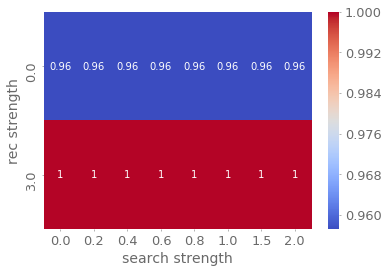

In [9]:
df = pd.DataFrame(summary_stats['identification_1'])
df = df[df['threshold']==0.5]
df = df.groupby(['rec strength', 'search strength']).mean().reset_index()
heatmap_data = df.pivot('rec strength', 'search strength', 'sensitivity')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.show()

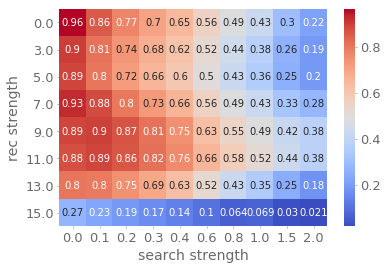

In [18]:
df = pd.DataFrame(summary_stats['identification_1'])
df = df[df['threshold']==0.5]
df = df.groupby(['rec strength', 'search strength']).mean().reset_index()
heatmap_data = df.pivot('rec strength', 'search strength', 'specificity')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.show()

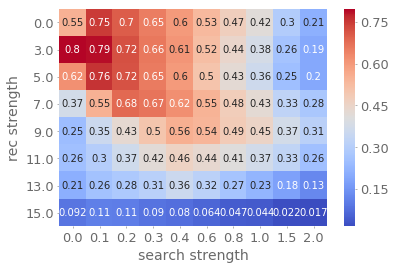

In [19]:
df = pd.DataFrame(summary_stats['identification_1'])
df['pdt'] = df['specificity'] * df['sensitivity']
df = df[df['threshold']==0.5]
df = df.groupby(['rec strength', 'search strength']).mean().reset_index()
heatmap_data = df.pivot('rec strength', 'search strength', 'pdt')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.show()

### What are the values at sites between cache 1 and cache 2?

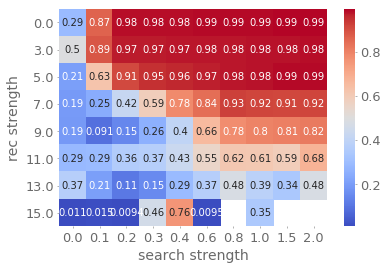

In [9]:
df = pd.DataFrame(summary_stats['identification_2'])
df = df[df['site spacing']==5]
df['binarized'] = 1 - (df['noncache val'] > 0.5)
df = df.groupby(['rec strength', 'search strength']).mean().reset_index()
heatmap_data = df.pivot('rec strength', 'search strength', 'noncache val')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.show()

### What are the values at non-caches away from a cache site?

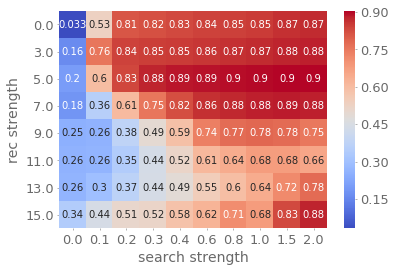

In [7]:
df = pd.DataFrame(summary_stats['identification_3'])
df = df[df['dist from attractor']==3]
df = df.groupby(['rec strength', 'search strength']).mean().reset_index()
heatmap_data = df.pivot('rec strength', 'search strength', 'val')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.show()

# Reconstruction

### Probability of valid attractor given optimal attractor distance

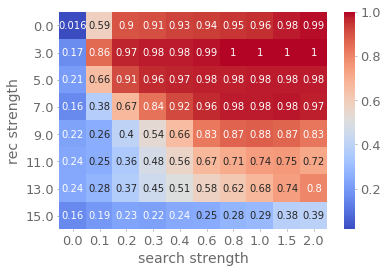

In [22]:
df = pd.DataFrame(summary_stats['reconstruct_1'])
df = df[df['opt attractor dist']==3]
df = df.groupby(['rec strength', 'search strength']).mean().reset_index()
heatmap_data = df.pivot('rec strength', 'search strength', 'p_valid')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.show()

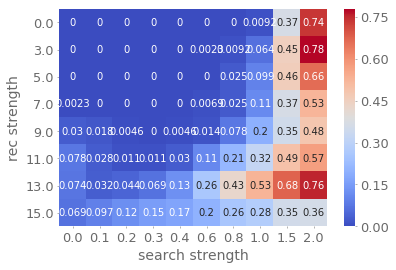

In [23]:
df = pd.DataFrame(summary_stats['reconstruct_1'])
df = df[df['opt attractor dist']==15]
df = df.groupby(['rec strength', 'search strength']).mean().reset_index()
heatmap_data = df.pivot('rec strength', 'search strength', 'p_valid')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.show()

### Conditioned on validity, what is the error?

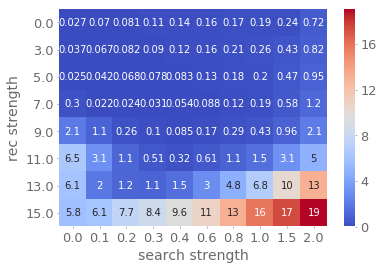

In [33]:
df = pd.DataFrame(summary_stats['reconstruct_2'])
df = df.groupby(['rec strength', 'search strength']).mean().reset_index()
heatmap_data = df.pivot('rec strength', 'search strength', 'chosen attractor dist')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.show()

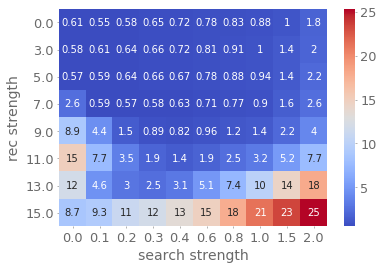

In [34]:
df = pd.DataFrame(summary_stats['reconstruct_2'])
df = df.groupby(['rec strength', 'search strength']).mean().reset_index()
heatmap_data = df.pivot('rec strength', 'search strength', 'norm error')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.show()

# Activations

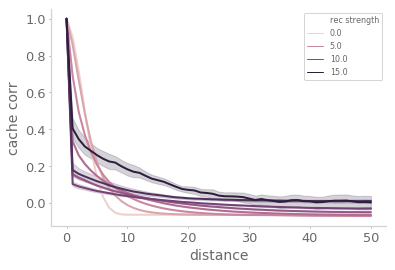

In [39]:
df = pd.DataFrame(summary_stats['activations_1'])
fig, ax = plt.subplots()
sns.lineplot(
    x='distance', y='cache corr', hue='rec strength',
    data=df, linewidth=2
    )
plt.show()